In [1]:
import numpy as np
import matplotlib.pyplot as plt

# Question 1: Monte Carlo Integral

In [2]:
# random number generator
def rand_number_generator(x):
    #a and m are hardcoded
    a = 65
    m = 1
    num = (a*x)%m
    return num

def rand_numbers(N, seed):
    numbers = np.zeros(N)
    for i in range(N):
        if i == 0:
            value = rand_number_generator(seed)
        else:
            value = rand_number_generator(value)
        numbers[i] = value
    
    return numbers

In [3]:
def monteCarlo(func, N):
    
    randnums = rand_numbers(N, 234.34)

    total = 0
    for i in randnums:
        total += func(i)

    total /= N 

    return total

In [4]:
def f(x):
    return np.exp(-x**2)

#for importance sampling
def p(x, alpha):
    return alpha * np.exp(-x)

### Without importance sampling

In [5]:
# Without importance sampling
integral = monteCarlo(f, 10000)
integral

0.7459725214732348

### With importance sampling

In [6]:
# With importance sampling
def g(x, alpha=1):
    return f(-np.log(1 - x/alpha)) / p(x, alpha)

integral_imp_sampled = monteCarlo(g, 10000)
integral_imp_sampled

0.7553025885846628

# Question 2: Schrodinger Equation in finite well

In [7]:
def lagrange_interpolation(zeta_h, zeta_l, yh, yl, y):
    return zeta_l + (zeta_h - zeta_l) * (y - yl) / (yh - yl)

def rk(de, step_size):
    d2ydx2, dydx, x0, y0, z0, xf = de
    
    x = []
    y = []
    z = []  # dy/dx
    x.append(x0)
    y.append(y0)
    z.append(z0)

    n = int((xf - x0) / step_size)  # no. of steps
    for i in range(n):
        x.append(x[i] + step_size)
        k1 = step_size * dydx(x[i], y[i], z[i])
        l1 = step_size * d2ydx2(x[i], y[i], z[i])
        k2 = step_size * dydx(x[i] + step_size / 2, y[i] + k1 / 2, z[i] + l1 / 2)
        l2 = step_size * d2ydx2(x[i] + step_size / 2, y[i] + k1 / 2, z[i] + l1 / 2)
        k3 = step_size * dydx(x[i] + step_size / 2, y[i] + k2 / 2, z[i] + l2 / 2)
        l3 = step_size * d2ydx2(x[i] + step_size / 2, y[i] + k2 / 2, z[i] + l2 / 2)
        k4 = step_size * dydx(x[i] + step_size, y[i] + k3, z[i] + l3)
        l4 = step_size * d2ydx2(x[i] + step_size, y[i] + k3, z[i] + l3)

        y.append(y[i] + (k1 + 2 * k2 + 2 * k3 + k4) / 6)
        z.append(z[i] + (l1 + 2 * l2 + 2 * l3 + l4) / 6)

    return x, y, z

def shooting_method_normaliized(de, step_size, tol=1e-6):
    #z is dy/dx
    d2ydx2, dydx, x0, y0, xf, yf, z_guess1, z_guess2 = de
    
    rk_de = [d2ydx2, dydx, x0, y0, z_guess1, xf]
    x, y, z = rk(rk_de, step_size)
    yn = y[-1]

    if abs(yn - yf) > tol:
        if yn < yf:
            zeta_l = z_guess1
            yl = yn
            
            rk_de = [d2ydx2, dydx, x0, y0, z_guess2, xf]
            x, y, z = rk(rk_de, step_size)
            yn = y[-1]

            if yn > yf:
                zeta_h = z_guess2
                yh = yn

                # calculate zeta using Lagrange interpolation
                zeta = lagrange_interpolation(zeta_h, zeta_l, yh, yl, yf)

                # using this zeta to solve using RK4
                rk_de = [d2ydx2, dydx, x0, y0, zeta, xf]
                x, y, z = rk(rk_de, step_size)
                print("solution found")
                y = y/np.linalg.norm(y)
                return x, y, z

            else:
                raise Exception("Failed. Choose another guess set.")

        elif yn > yf:
            zeta_h = z_guess1
            yh = yn

            rk_de = [d2ydx2, dydx, x0, y0, z_guess2, xf]
            x, y, z = rk(rk_de, step_size)
            yn = y[-1]

            if yn < yf:
                zeta_l = z_guess2
                yl = yn

                # calculate zeta using Lagrange interpolation
                zeta = lagrange_interpolation(zeta_h, zeta_l, yh, yl, yf)
                
                rk_de = [d2ydx2, dydx, x0, y0, zeta, xf]
                x, y, z = rk(rk_de, step_size)
                y = y/np.linalg.norm(y)
                print("solution found")
                return x, y, z

            else:
                raise Exception("Failed. Choose another guess set.")

    else:
        y = y/np.linalg.norm(y)
        print("solution found")
        return x, y, z 

In [8]:
E1 = np.pi**2
E2 = 4 * E1

x0, xf = [0.0, 1.0]
y0, yf = [0.0, 0.0]
z1_guess1, z1_guess2 = [3.0, 0.0]
z2_guess1, z2_guess2 = [-1.0, 3.0]
dx = 0.02

def dzdx1(x, y, z):
    return -E1 * y
def dzdx2(x, y, z):
    return -E2 * y
def dydx(x, y, z):
    return z

params1 = [dzdx1, dydx, x0, y0, xf, yf, z1_guess1, z1_guess2]
params2 = [dzdx2, dydx, x0, y0, xf, yf, z2_guess1, z2_guess2]
x1, y1, z1 = shooting_method_normaliized(params1, dx)
x2, y2, z2 = shooting_method_normaliized(params2, dx)

solution found
solution found


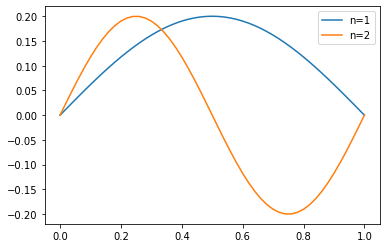

In [9]:
plt.plot(x1, y1, label="n=1")
plt.plot(x2, y2, label="n=2")
plt.legend()
plt.show()

# Question 3: Laplace Equation

In [10]:
def jacobi(u0, lim = 50):
    u = u0.copy()
    run = 0
    while run <= lim:
        for i in range(1, n):
            for j in range(1, n):
                u[i][j] = 1/4 * (u0[i][j+1] + u0[i][j-1] + u0[i+1][j] + u0[i-1][j])
                u0[i][j] = u[i][j]

        run += 1
        
    return u

def laplace(l, n, boundary_conditions, lim = 50):
    xb0, xb1, yb0, yb1 = boundary_conditions

    dx = l/n
    dy = l/n

    u0 = [[0 for i in range(n+1)] for j in range(n+1)]  
    x = [i * dx for i in range(n+1)]
    y = [j * dy for j in range(n+1)]

    # boundary conditions
    for i in range(n+1):
        u0[0][i] = xb0
        u0[n][i] = xb1
        u0[i][0] = yb0
        u0[i][n] = yb1

    u = jacobi(u0, lim)

    return u, x, y

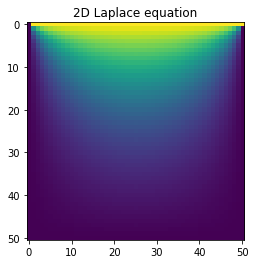

In [11]:
l = 1.0
n = 50
boundary_conditions = [1.0, 0.0, 0.0, 0.0]

u, x, y = laplace(l, n, boundary_conditions, 1000)
plt.imshow(u)
plt.title("2D Laplace equation")
plt.show()